# Stock Price Prediction of Microsoft

Importing necessary Libraries

In [93]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
from sklearn.preprocessing import MinMaxScaler
from keras.layers import LSTM, Dense, Dropout, GRU, SimpleRNN, Conv1D, MaxPooling1D, Flatten
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.dates as mdates
from sklearn import linear_model

# Reading data using parse date
As it is timeseries data so we have to read the data by parsing date means making data column as index.

In [97]:
df_final = pd.read_csv("MSFT (2).csv", na_values=['null'], index_col='Date', parse_dates=True, infer_datetime_format=True)

<ipython-input-97-899f524711e9>:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_final = pd.read_csv("MSFT (2).csv", na_values=['null'], index_col='Date', parse_dates=True, infer_datetime_format=True)


# Performing EDA Analysis

In [98]:
df_final.shape


(9666, 6)

In [99]:
df_final.head()


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1986-03-13,0.088542,0.101563,0.088542,0.097222,0.060055,1031788800
1986-03-14,0.097222,0.102431,0.097222,0.100694,0.062199,308160000
1986-03-17,0.100694,0.103299,0.100694,0.102431,0.063272,133171200
1986-03-18,0.102431,0.103299,0.098958,0.099826,0.061663,67766400
1986-03-19,0.099826,0.100694,0.097222,0.098090,0.060591,47894400


In [100]:
df_final.describe()

,Open,High,Low,Close,Adj Close,Volume
count,9666.000000,9666.000000,9666.000000,9666.000000,9666.000000,9.666000e+03
mean,58.170434,58.769700,57.557072,58.188367,52.581593,5.679741e+07
std,89.668442,90.502899,88.790545,89.703225,89.771261,3.814365e+07
min,0.088542,0.092014,0.088542,0.090278,0.055765,2.304000e+06
25%,5.689453,5.758789,5.611328,5.686524,3.512596,3.208752e+07
50%,27.299999,27.575000,27.070000,27.335000,19.179433,4.991070e+07
75%,46.645002,47.087501,46.118749,46.623750,38.255783,7.077375e+07
max,467.000000,468.350006,464.459991,467.559998,467.559998,1.031789e+09


In [101]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9666 entries, 1986-03-13 to 2024-07-22
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       9666 non-null   float64
 1   High       9666 non-null   float64
 2   Low        9666 non-null   float64
 3   Close      9666 non-null   float64
 4   Adj Close  9666 non-null   float64
 5   Volume     9666 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 528.6 KB


In [102]:
df_final.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

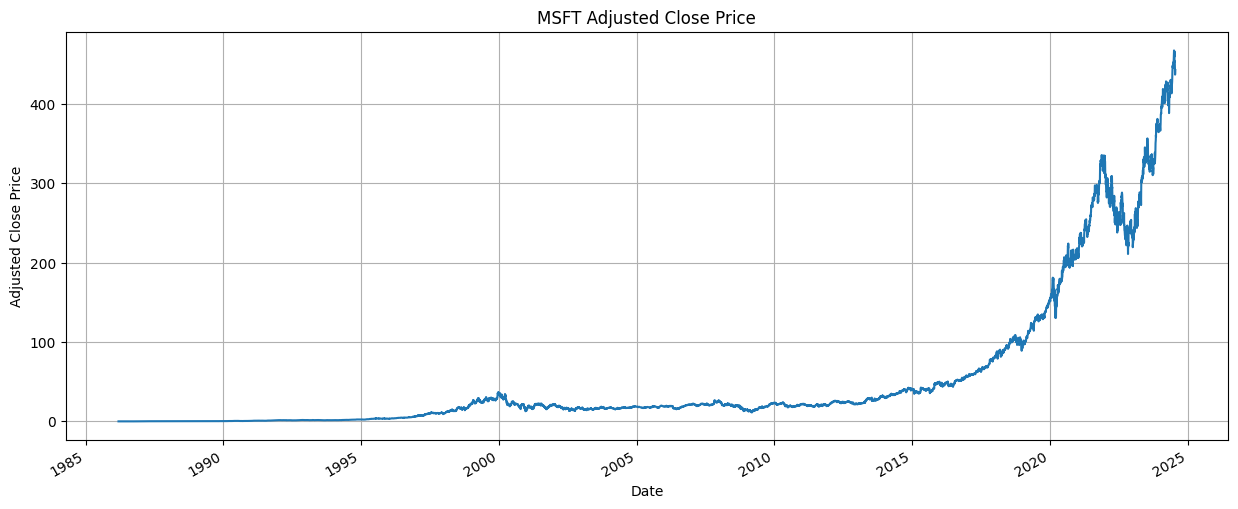

In [103]:
df_final['Adj Close'].plot(figsize=(15, 6))
plt.title('MSFT Adjusted Close Price')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.grid(True)
plt.show()

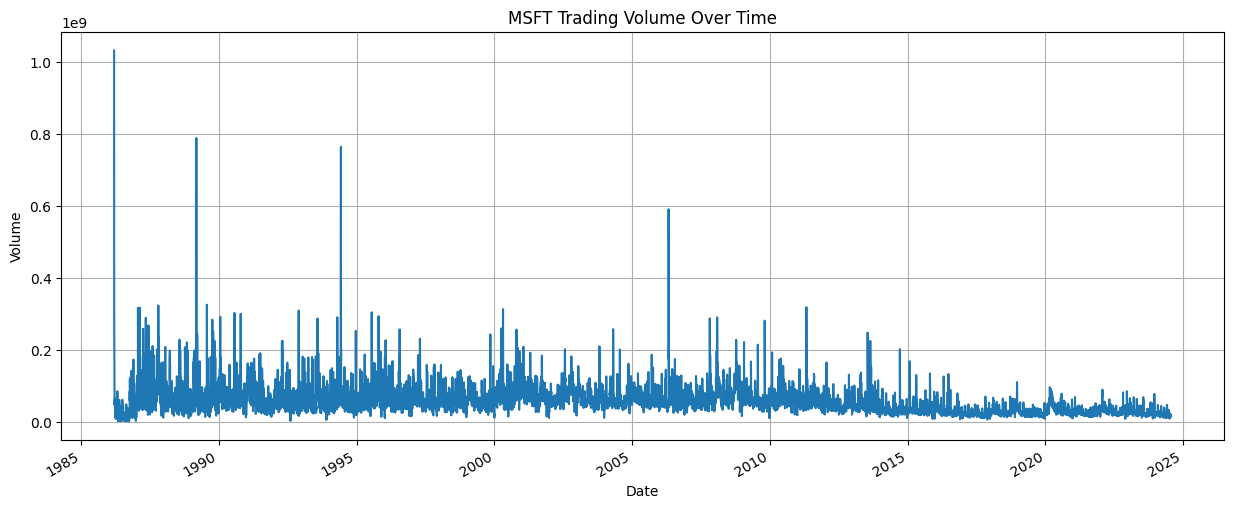

In [104]:
plt.figure(figsize=(15, 6))
df_final['Volume'].plot()
plt.title('MSFT Trading Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.grid(True)
plt.show()

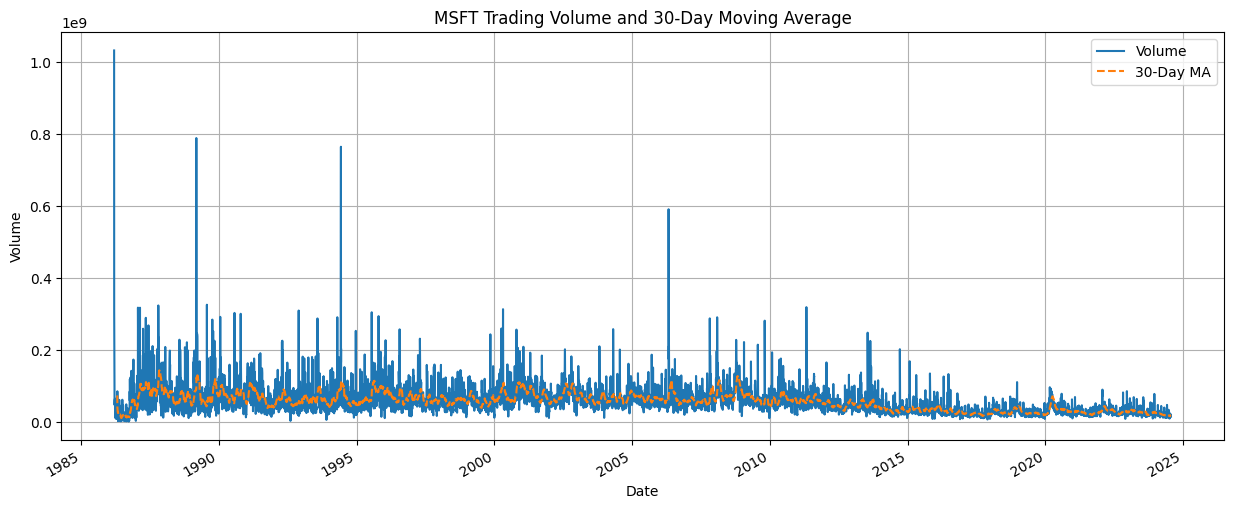

In [105]:
df_final['Volume_MA30'] = df_final['Volume'].rolling(window=30).mean()
plt.figure(figsize=(15, 6))
df_final['Volume'].plot(label='Volume')
df_final['Volume_MA30'].plot(label='30-Day MA', linestyle='--')
plt.title('MSFT Trading Volume and 30-Day Moving Average')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.grid(True)
plt.show()

In [108]:
df_final['MA20'] = df_final['Adj Close'].rolling(window=20).mean()
df_final['MA50'] = df_final['Adj Close'].rolling(window=50).mean()
df_final['MA100'] = df_final['Adj Close'].rolling(window=100).mean()

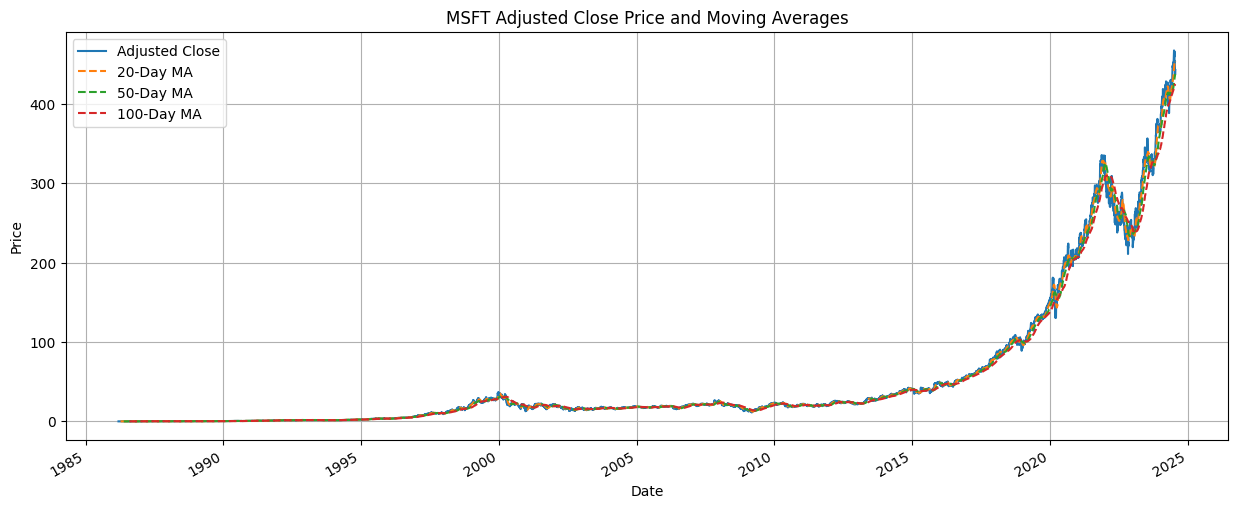

In [109]:
plt.figure(figsize=(15, 6))
df_final['Adj Close'].plot(label='Adjusted Close')
df_final['MA20'].plot(label='20-Day MA', linestyle='--')
df_final['MA50'].plot(label='50-Day MA', linestyle='--')
df_final['MA100'].plot(label='100-Day MA', linestyle='--')
plt.title('MSFT Adjusted Close Price and Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Enhanced EDA

In [110]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df_final['Adj Close'], model='multiplicative', period=30)

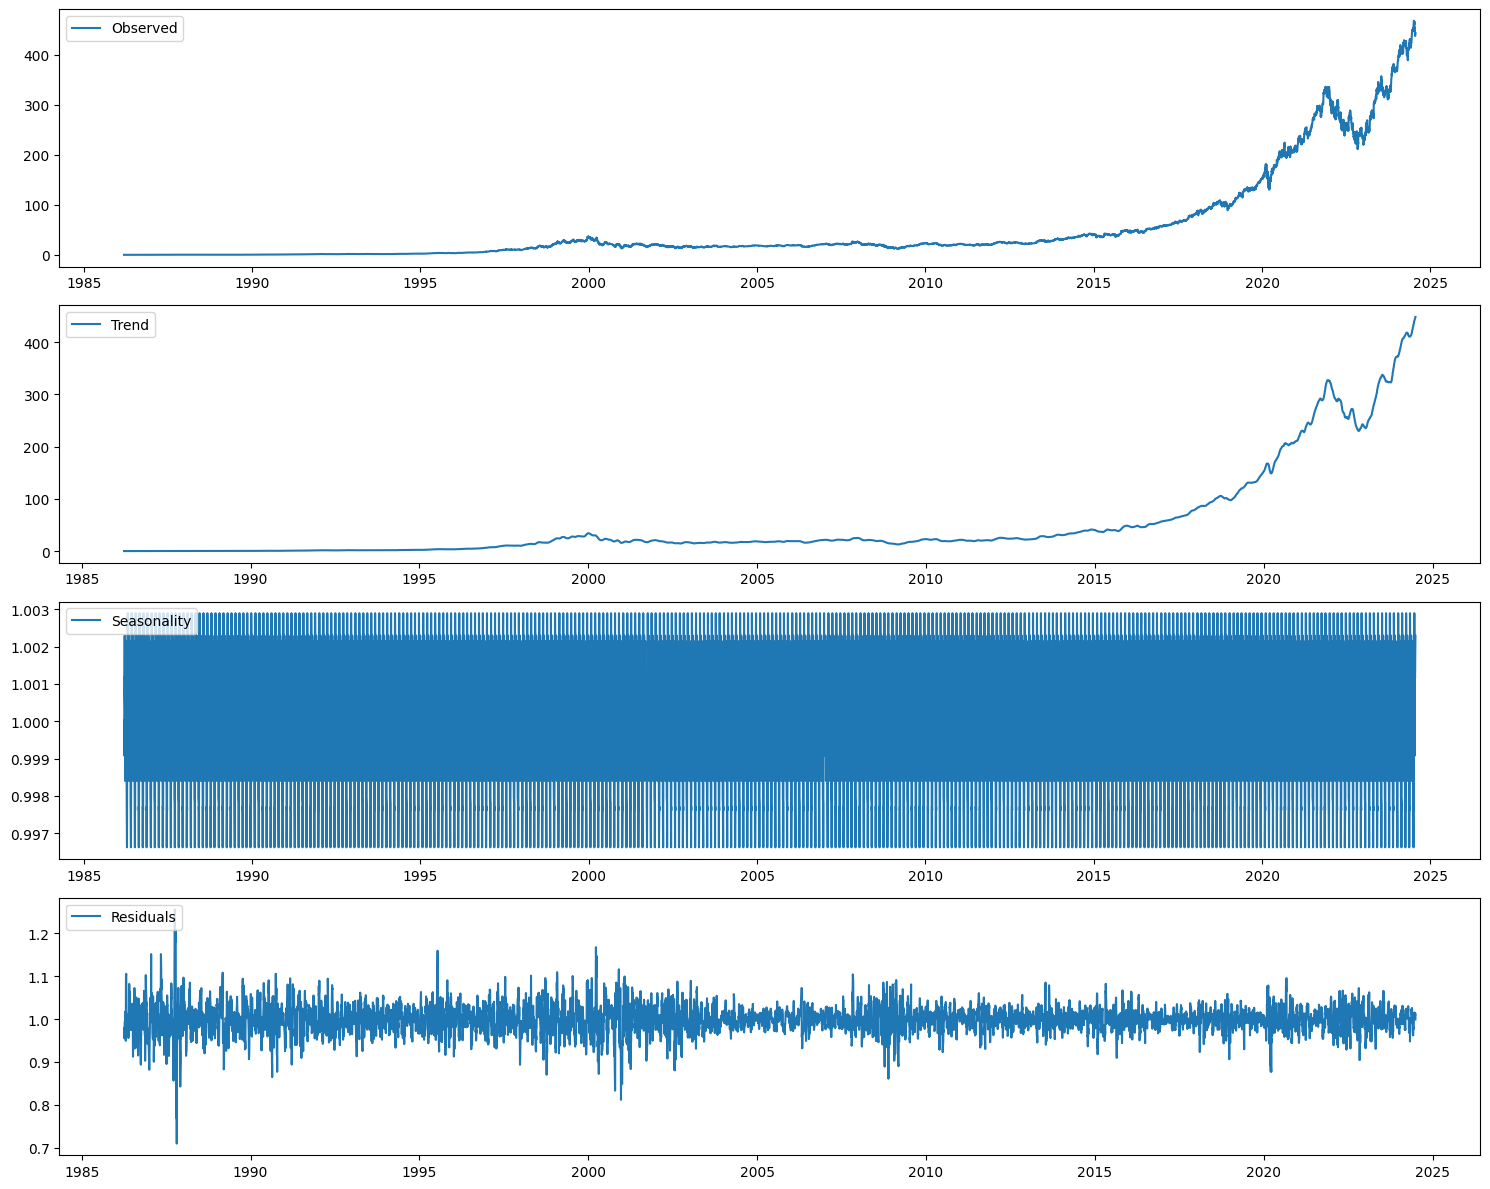

In [111]:
plt.figure(figsize=(15, 12))
plt.subplot(411)
plt.plot(decomposition.observed, label='Observed')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(decomposition.trend, label='Trend')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonality')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(decomposition.resid, label='Residuals')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

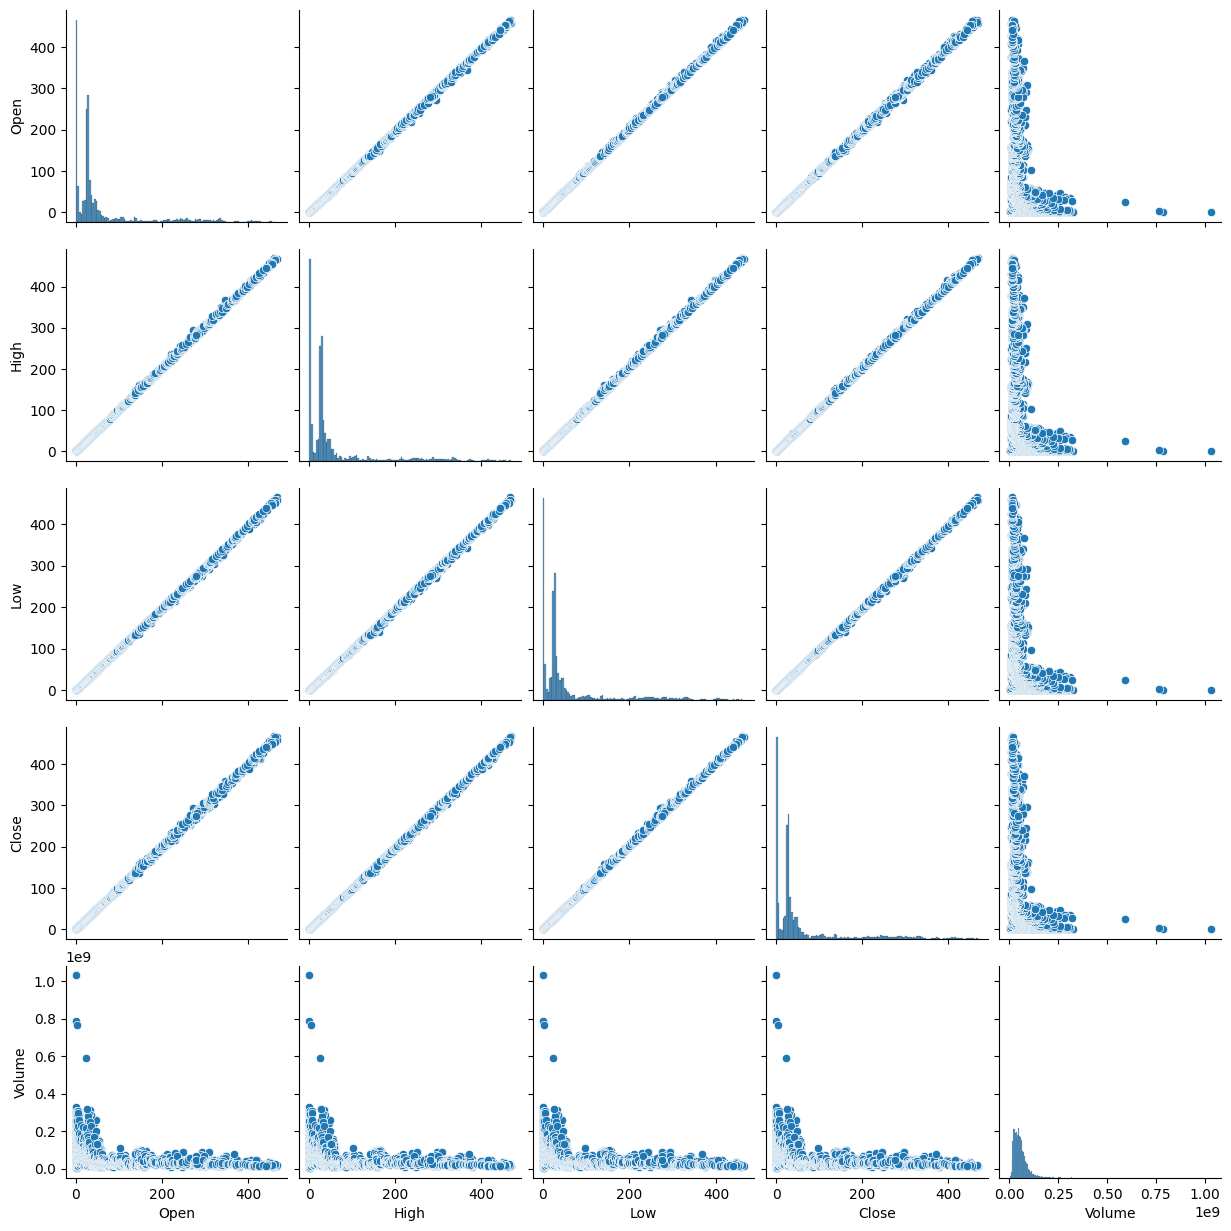

In [112]:
import seaborn as sns
sns.pairplot(df_final[['Open', 'High', 'Low', 'Close', 'Volume']])
plt.show()

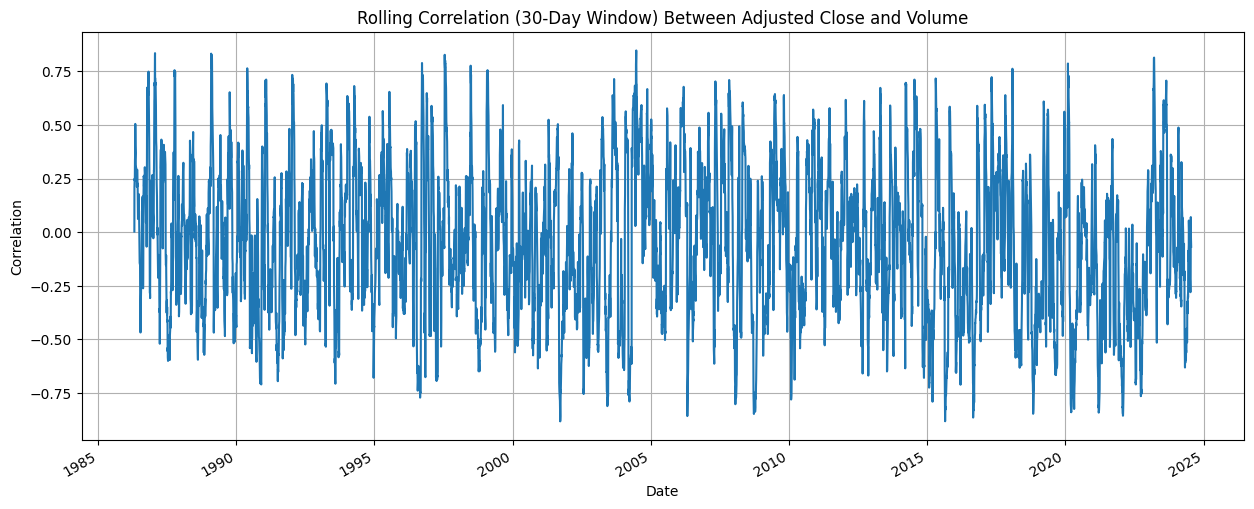

In [113]:
rolling_corr = df_final['Adj Close'].rolling(window=30).corr(df_final['Volume'])
plt.figure(figsize=(15, 6))
rolling_corr.plot()
plt.title('Rolling Correlation (30-Day Window) Between Adjusted Close and Volume')
plt.xlabel('Date')
plt.ylabel('Correlation')
plt.grid(True)
plt.show()

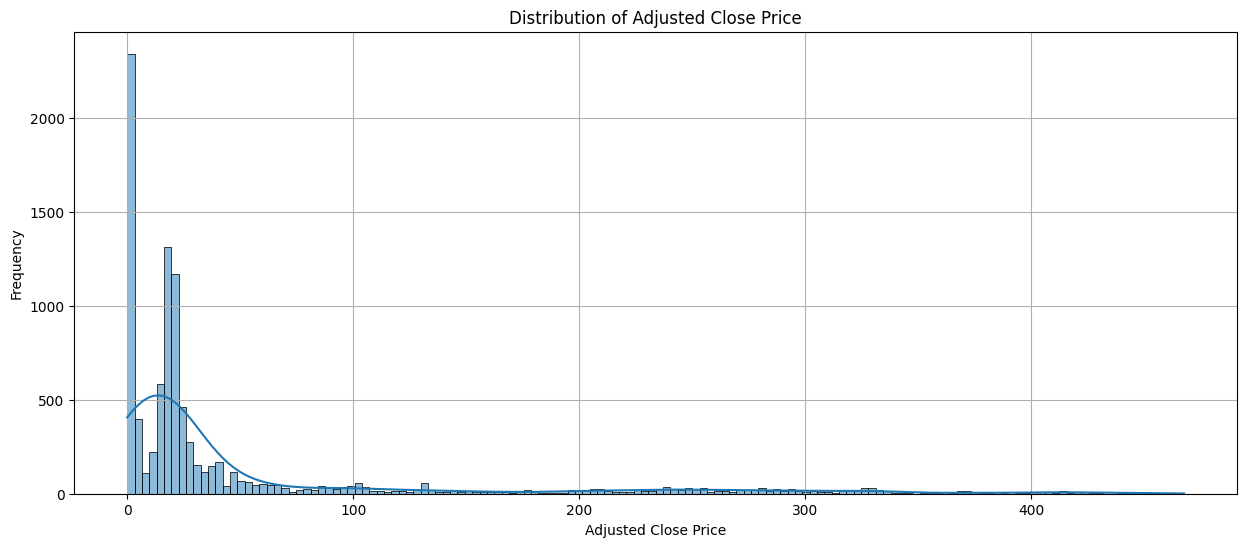

In [114]:
plt.figure(figsize=(15, 6))
sns.histplot(df_final['Adj Close'], kde=True)
plt.title('Distribution of Adjusted Close Price')
plt.xlabel('Adjusted Close Price')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

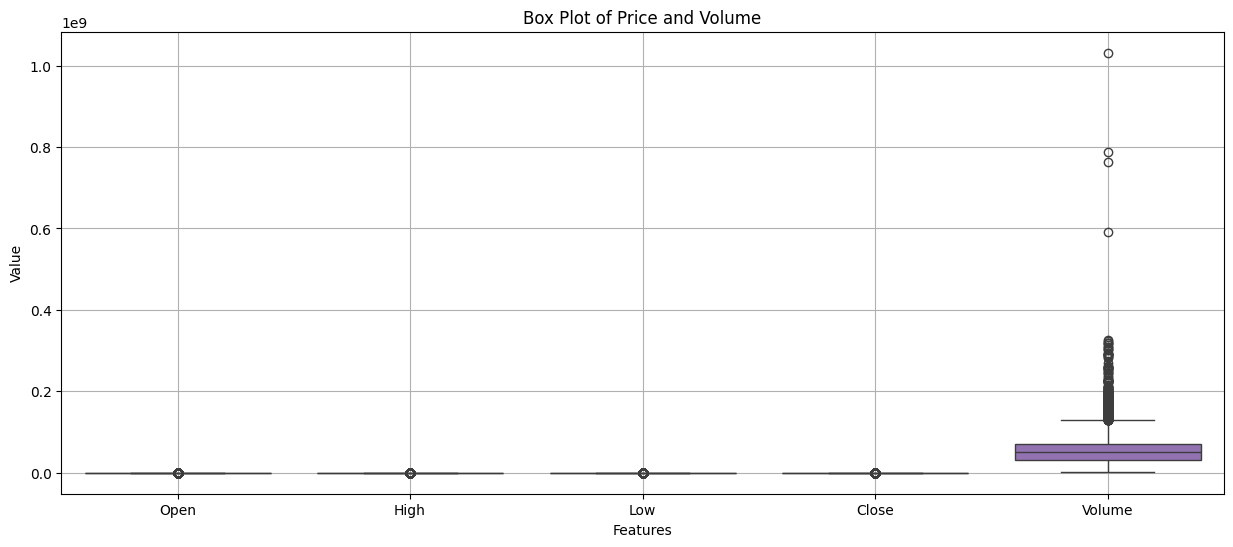

In [115]:
plt.figure(figsize=(15, 6))
sns.boxplot(data=df_final[['Open', 'High', 'Low', 'Close', 'Volume']])
plt.title('Box Plot of Price and Volume')
plt.xlabel('Features')
plt.ylabel('Value')
plt.grid(True)
plt.show()

In [116]:
df_final.describe()

,Open,High,Low,Close,Adj Close,Volume,Volume_MA30,MA20,MA50,MA100
count,9666.000000,9666.000000,9666.000000,9666.000000,9666.000000,9.666000e+03,9.637000e+03,9647.000000,9617.000000,9567.000000
mean,58.170434,58.769700,57.557072,58.188367,52.581593,5.679741e+07,5.675522e+07,52.240686,51.714070,50.884491
std,89.668442,90.502899,88.790545,89.703225,89.771261,3.814365e+07,2.304686e+07,88.924154,87.634450,85.658010
min,0.088542,0.092014,0.088542,0.090278,0.055765,2.304000e+06,1.183488e+07,0.059411,0.062532,0.064690
25%,5.689453,5.758789,5.611328,5.686524,3.512596,3.208752e+07,3.678084e+07,3.565845,3.568394,3.578947
50%,27.299999,27.575000,27.070000,27.335000,19.179433,4.991070e+07,5.803010e+07,19.125291,19.178070,19.215143
75%,46.645002,47.087501,46.118749,46.623750,38.255783,7.077375e+07,7.058439e+07,38.423564,38.717546,38.424207
max,467.000000,468.350006,464.459991,467.559998,467.559998,1.031789e+09,1.438459e+08,454.443501,437.810519,425.350988


In [117]:
df_final.isnull().sum()

Open            0
High            0
Low             0
Close           0
Adj Close       0
Volume          0
Volume_MA30    29
MA20           19
MA50           49
MA100          99
dtype: int64

In [118]:

df_final.dropna(inplace=True)
df_final.isnull().sum()


Open           0
High           0
Low            0
Close          0
Adj Close      0
Volume         0
Volume_MA30    0
MA20           0
MA50           0
MA100          0
dtype: int64

# Correlation Analysis

In [119]:
correlation_matrix = df_final.corr()
correlation_matrix


,Open,High,Low,Close,Adj Close,Volume,Volume_MA30,MA20,MA50,MA100
Open,1.000000,0.999946,0.999939,0.999871,0.998840,-0.365023,-0.581081,0.998225,0.997223,0.995537
High,0.999946,1.000000,0.999922,0.999936,0.998869,-0.363987,-0.580463,0.998235,0.997302,0.995668
Low,0.999939,0.999922,1.000000,0.999943,0.998945,-0.366207,-0.581732,0.998150,0.997092,0.995360
Close,0.999871,0.999936,0.999943,1.000000,0.998969,-0.365171,-0.581110,0.998140,0.997143,0.995472
Adj Close,0.998840,0.998869,0.998945,0.998969,1.000000,-0.364508,-0.580054,0.999173,0.998157,0.996461
Volume,-0.365023,-0.363987,-0.366207,-0.365171,-0.364508,1.000000,0.579908,-0.362870,-0.361548,-0.360683
Volume_MA30,-0.581081,-0.580463,-0.581732,-0.581110,-0.580054,0.579908,1.000000,-0.579407,-0.577073,-0.574760
MA20,0.998225,0.998235,0.998150,0.998140,0.999173,-0.362870,-0.579407,1.000000,0.999332,0.997763
MA50,0.997223,0.997302,0.997092,0.997143,0.998157,-0.361548,-0.577073,0.999332,1.000000,0.999133
MA100,0.995537,0.995668,0.995360,0.995472,0.996461,-0.360683,-0.574760,0.997763,0.999133,1.000000


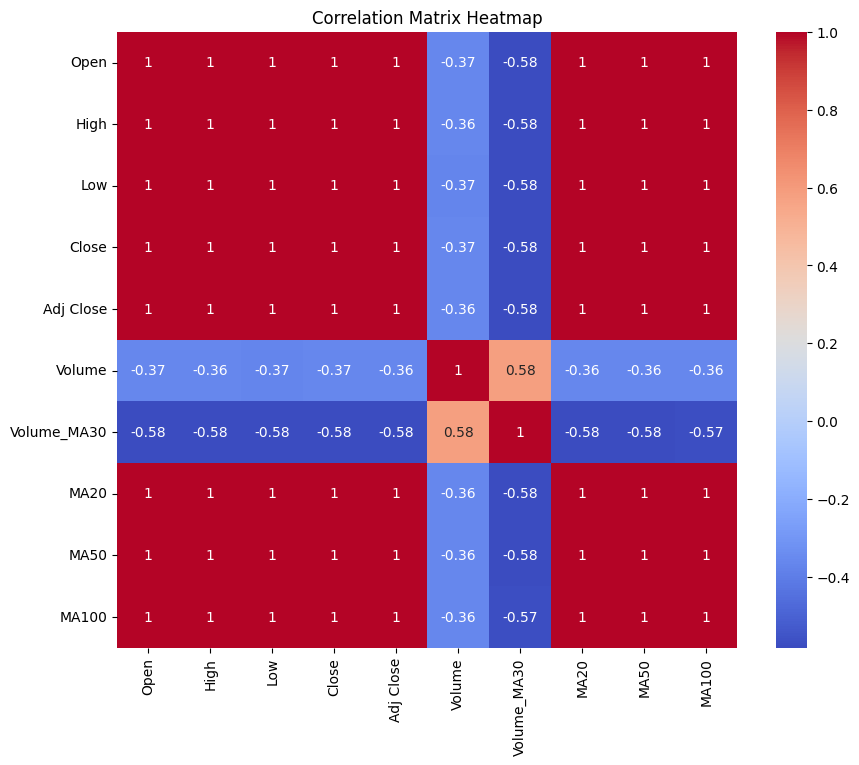

In [120]:
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

In [121]:
X = df_final.drop(['Adj Close'], axis=1)
X = X.drop(['Close'], axis=1)

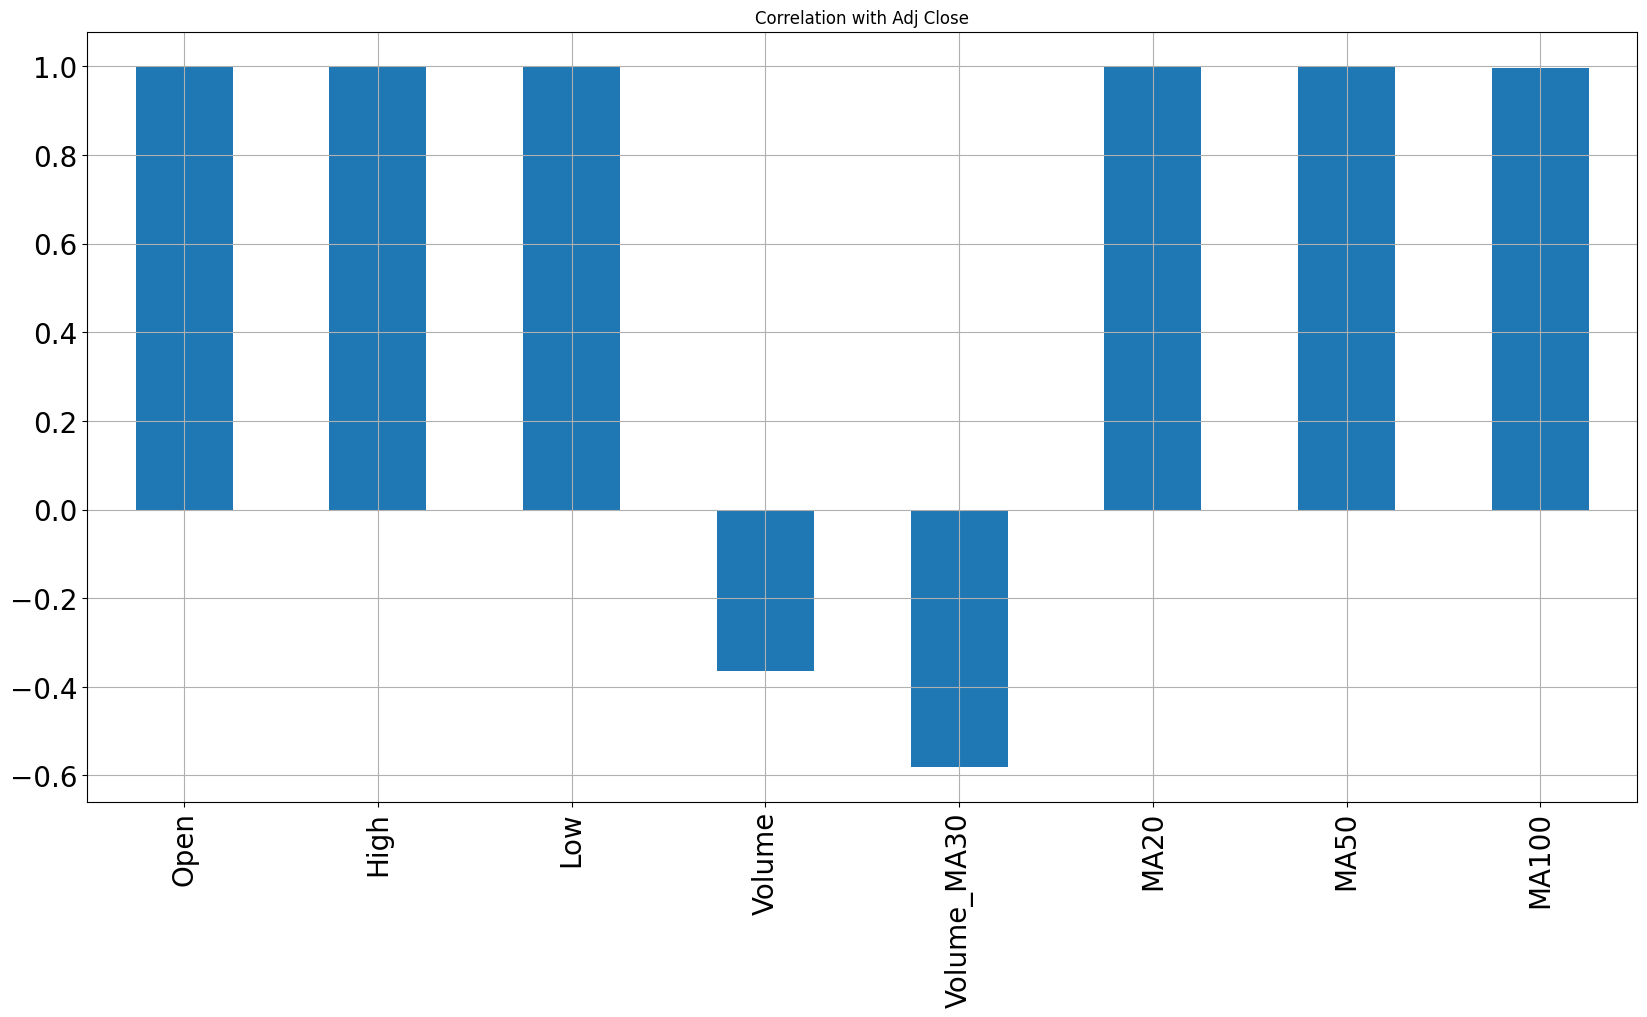

In [122]:
X.corrwith(df_final['Adj Close']).plot.bar(
    figsize=(20, 10), title="Correlation with Adj Close", fontsize=20,
    rot=90, grid=True
)
plt.show()

In [123]:
test = df_final
target_adj_close = pd.DataFrame(test['Adj Close'])

In [124]:
# selecting Feature Columns
feature_columns = ['Open', 'High', 'Low', 'Volume']


# Normalizing the data

In [125]:
scaler = MinMaxScaler()
feature_minmax_transform_data = scaler.fit_transform(test[feature_columns])
feature_minmax_transform = pd.DataFrame(columns=feature_columns, data=feature_minmax_transform_data, index=test.index)


In [126]:
feature_minmax_transform.head()

,Open,High,Low,Volume
Date,,,,
1986-08-04,0.000006,0.000006,0.000009,0.012855
1986-08-05,0.000006,0.000007,0.000013,0.000623
1986-08-06,0.000004,0.000006,0.000007,0.020327
1986-08-07,0.000002,0.000004,0.000007,0.001685
1986-08-08,0.000000,0.000006,0.000009,0.002307


In [127]:
target_adj_close = target_adj_close.shift(-1)
validation_y = target_adj_close[-90:-1]
target_adj_close = target_adj_close[:-90]

In [128]:
validation_X = feature_minmax_transform[-90:-1]
feature_minmax_transform = feature_minmax_transform[:-90]


In [129]:
validation_X.tail()

,Open,High,Low,Volume
Date,,,,
2024-07-15,0.970658,0.976316,0.971940,0.015383
2024-07-16,0.972628,0.969995,0.961668,0.018876
2024-07-17,0.947719,0.949814,0.945561,0.024728
2024-07-18,0.951468,0.949386,0.935267,0.023478
2024-07-19,0.927394,0.941891,0.930099,0.023663


#-----After process------

In [130]:
target_adj_close.tail()

,Adj Close
Date,
2024-03-06,408.403381
2024-03-07,405.488617
2024-03-08,403.791656
2024-03-11,414.532288
2024-03-12,414.352631


In [131]:
feature_minmax_transform.shape


(9477, 4)

In [132]:
target_adj_close.shape

(9477, 1)

In [133]:
ts_split = TimeSeriesSplit(n_splits=10)
for train_index, test_index in ts_split.split(feature_minmax_transform):
    X_train, X_test = feature_minmax_transform[:len(train_index)], feature_minmax_transform[len(train_index): (len(train_index)+len(test_index))]
    y_train, y_test = target_adj_close[:len(train_index)].values.ravel(), target_adj_close[len(train_index): (len(train_index)+len(test_index))].values.ravel()

In [134]:
X_train = np.array(X_train)
X_test = np.array(X_test)
X_tr_t = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_tst_t = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [135]:
def validate_result(model, model_name):
    predicted = model.predict(validation_X)
    RSME_score = np.sqrt(mean_squared_error(validation_y, predicted))
    print(f'{model_name} RMSE: {RSME_score}')

    R2_score = r2_score(validation_y, predicted)
    print(f'{model_name} R2 score: {R2_score}')

    plt.plot(validation_y.index, predicted, 'r', label='Predict')
    plt.plot(validation_y.index, validation_y, 'b', label='Actual')
    plt.ylabel('Price')
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.title(f'{model_name} Predict vs Actual')
    plt.legend(loc='upper right')
    plt.show()

# Importing different Neural Nework from keras lib

In [138]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, SimpleRNN, Conv1D, MaxPooling1D, Flatten
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

# Model building : LSTM

In [139]:
K.clear_session()
model_lstm = Sequential()
model_lstm.add(LSTM(16, input_shape=(1, X_train.shape[1]), activation='relu', return_sequences=False))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
history_model_lstm = model_lstm.fit(X_tr_t, y_train, epochs=200, batch_size=8, verbose=1, shuffle=False, callbacks=[early_stop])

Epoch 1/200
1077/1077 [==============================] - 4s 2ms/step - loss: 640.9137
Epoch 2/200
1077/1077 [==============================] - 2s 2ms/step - loss: 698.7635
Epoch 3/200
1077/1077 [==============================] - 4s 3ms/step - loss: 586.8599
Epoch 4/200
1077/1077 [==============================] - 3s 3ms/step - loss: 431.4573
Epoch 5/200
1077/1077 [==============================] - 2s 2ms/step - loss: 294.2122
Epoch 6/200
1077/1077 [==============================] - 2s 2ms/step - loss: 183.2686
Epoch 7/200
1077/1077 [==============================] - 2s 2ms/step - loss: 103.4512
Epoch 8/200
1077/1077 [==============================] - 3s 3ms/step - loss: 54.3065
Epoch 9/200
1077/1077 [==============================] - 3s 3ms/step - loss: 28.3703
Epoch 10/200
1077/1077 [==============================] - 2s 2ms/step - loss: 15.3637
Epoch 11/200
1077/1077 [==============================] - 2s 2ms/step - loss: 9.2668
Epoch 12/200
1077/1077 [==============================] -

# Evaluation of LSTM Model

In [140]:
y_pred_test_lstm = model_lstm.predict(X_tst_t)
y_train_pred_lstm = model_lstm.predict(X_tr_t)
print(f"LSTM R2 score on Train set: {r2_score(y_train, y_train_pred_lstm):.3f}")
print(f"LSTM R2 score on Test set: {r2_score(y_test, y_pred_test_lstm):.3f}")
score_lstm = model_lstm.evaluate(X_tst_t, y_test, batch_size=1)
print(f'LSTM loss: {score_lstm:.6f}')

270/270 [==============================] - 0s 1ms/step
LSTM R2 score on Train set: 0.987
LSTM R2 score on Test set: 0.780
861/861 [==============================] - 2s 2ms/step - loss: 578.2924
LSTM loss: 578.292419


# Plotting Predictions made by LSTM

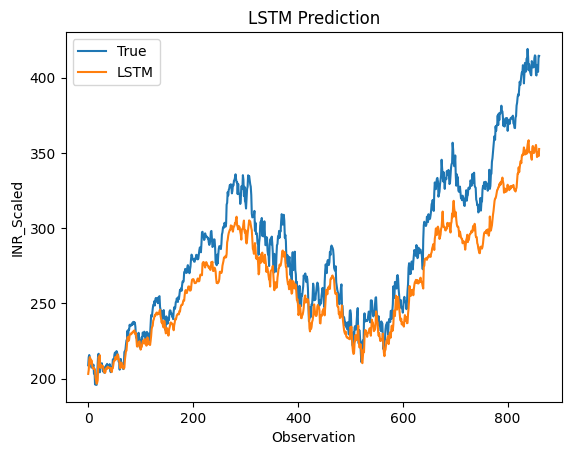

In [141]:
plt.plot(y_test, label='True')
plt.plot(y_pred_test_lstm, label='LSTM')
plt.title("LSTM Prediction")
plt.xlabel('Observation')
plt.ylabel('INR_Scaled')
plt.legend()
plt.show()

# Mode Building : GRU

In [142]:
K.clear_session()
model_gru = Sequential()
model_gru.add(GRU(16, input_shape=(1, X_train.shape[1]), activation='relu', return_sequences=False))
model_gru.add(Dense(1))
model_gru.compile(loss='mean_squared_error', optimizer='adam')
history_model_gru = model_gru.fit(X_tr_t, y_train, epochs=200, batch_size=8, verbose=1, shuffle=False, callbacks=[early_stop])

Epoch 1/200
1077/1077 [==============================] - 4s 3ms/step - loss: 660.4341
Epoch 2/200
1077/1077 [==============================] - 2s 2ms/step - loss: 896.5320
Epoch 3/200
1077/1077 [==============================] - 2s 2ms/step - loss: 765.6290
Epoch 4/200
1077/1077 [==============================] - 2s 2ms/step - loss: 515.2952
Epoch 5/200
1077/1077 [==============================] - 3s 3ms/step - loss: 324.8815
Epoch 6/200
1077/1077 [==============================] - 3s 3ms/step - loss: 188.4422
Epoch 7/200
1077/1077 [==============================] - 2s 2ms/step - loss: 99.6727
Epoch 8/200
1077/1077 [==============================] - 2s 2ms/step - loss: 50.7169
Epoch 9/200
1077/1077 [==============================] - 2s 2ms/step - loss: 27.3281
Epoch 10/200
1077/1077 [==============================] - 3s 2ms/step - loss: 16.6348
Epoch 11/200
1077/1077 [==============================] - 4s 3ms/step - loss: 11.2202
Epoch 12/200
1077/1077 [==============================] -

# Evaluation of GRU Model

In [143]:
y_pred_test_gru = model_gru.predict(X_tst_t)
print(f"GRU R2 score on Train set: {r2_score(y_train, model_gru.predict(X_tr_t)):.3f}")
print(f"GRU R2 score on Test set: {r2_score(y_test, y_pred_test_gru):.3f}")
score_gru = model_gru.evaluate(X_tst_t, y_test, batch_size=1)
print(f'GRU loss: {score_gru:.6f}')

270/270 [==============================] - 0s 2ms/step
GRU R2 score on Train set: 0.980
GRU R2 score on Test set: 0.276
861/861 [==============================] - 2s 2ms/step - loss: 1907.9910
GRU loss: 1907.990967


# Plotting Predictions made by GRU

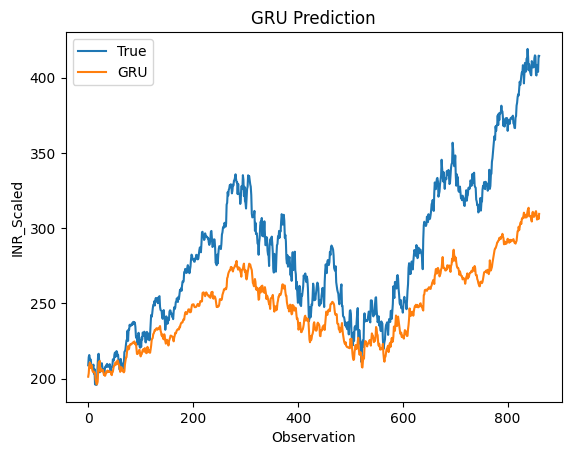

In [144]:
plt.plot(y_test, label='True')
plt.plot(y_pred_test_gru, label='GRU')
plt.title("GRU Prediction")
plt.xlabel('Observation')
plt.ylabel('INR_Scaled')
plt.legend()
plt.show()

# Model Building : SimpleRNN

In [145]:
K.clear_session()
model_simplernn = Sequential()
model_simplernn.add(SimpleRNN(16, input_shape=(1, X_train.shape[1]), activation='relu', return_sequences=False))
model_simplernn.add(Dense(1))
model_simplernn.compile(loss='mean_squared_error', optimizer='adam')
history_model_simplernn = model_simplernn.fit(X_tr_t, y_train, epochs=200, batch_size=8, verbose=1, shuffle=False, callbacks=[early_stop])

Epoch 1/200
1077/1077 [==============================] - 4s 2ms/step - loss: 645.0673
Epoch 2/200
1077/1077 [==============================] - 2s 2ms/step - loss: 805.1280
Epoch 3/200
1077/1077 [==============================] - 2s 2ms/step - loss: 771.3887
Epoch 4/200
1077/1077 [==============================] - 2s 2ms/step - loss: 654.3801
Epoch 5/200
1077/1077 [==============================] - 2s 2ms/step - loss: 543.8788
Epoch 6/200
1077/1077 [==============================] - 4s 3ms/step - loss: 434.3861
Epoch 7/200
1077/1077 [==============================] - 2s 2ms/step - loss: 326.8706
Epoch 8/200
1077/1077 [==============================] - 2s 2ms/step - loss: 227.0943
Epoch 9/200
1077/1077 [==============================] - 2s 2ms/step - loss: 142.2957
Epoch 10/200
1077/1077 [==============================] - 2s 2ms/step - loss: 79.9682
Epoch 11/200
1077/1077 [==============================] - 3s 3ms/step - loss: 42.8870
Epoch 12/200
1077/1077 [==============================

# Evaluation of SimpleRNN

In [146]:
y_pred_test_simplernn = model_simplernn.predict(X_tst_t)
print(f"SimpleRNN R2 score on Train set: {r2_score(y_train, model_simplernn.predict(X_tr_t)):.3f}")
print(f"SimpleRNN R2 score on Test set: {r2_score(y_test, y_pred_test_simplernn):.3f}")
score_simplernn = model_simplernn.evaluate(X_tst_t, y_test, batch_size=1)
print(f'SimpleRNN loss: {score_simplernn:.6f}')

270/270 [==============================] - 0s 1ms/step
SimpleRNN R2 score on Train set: 0.982
SimpleRNN R2 score on Test set: 0.905
861/861 [==============================] - 2s 2ms/step - loss: 251.4884
SimpleRNN loss: 251.488403


# Plotting Predictions made by SimpleRNN

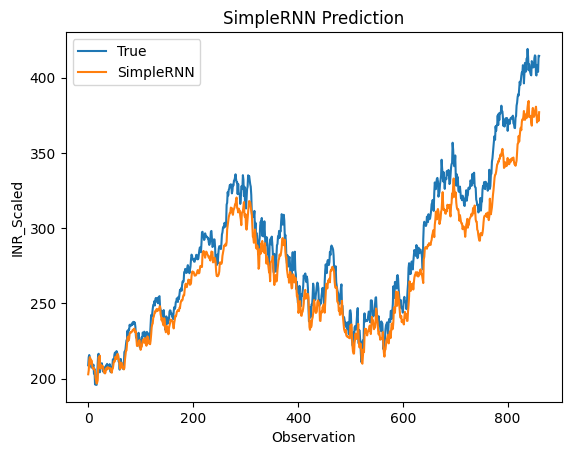

In [147]:
plt.plot(y_test, label='True')
plt.plot(y_pred_test_simplernn, label='SimpleRNN')
plt.title("SimpleRNN Prediction")
plt.xlabel('Observation')
plt.ylabel('INR_Scaled')
plt.legend()
plt.show()

# Model building : CNN1D

In [148]:
seq_length = 5  # Example sequence length

def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
    return np.array(sequences)

# Create sequences for training and testing
X_tr_t_cnn = create_sequences(X_train, seq_length)
X_tst_t_cnn = create_sequences(X_test, seq_length)

# Adjust the target variable for the sequence length
y_train_cnn = y_train[seq_length:]
y_test_cnn = y_test[seq_length:]

In [149]:
X_tr_t_cnn.shape

(8611, 5, 4)

In [150]:
X_tst_t_cnn.shape

(856, 5, 4)

In [151]:
y_train_cnn.shape

(8611,)

In [152]:
K.clear_session()
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(seq_length, X_train.shape[1])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(1))
model_cnn.compile(loss='mean_squared_error', optimizer='adam')
history_model_cnn = model_cnn.fit(X_tr_t_cnn, y_train_cnn, epochs=200, batch_size=8, verbose=1, shuffle=False, callbacks=[early_stop])

Epoch 1/200
1077/1077 [==============================] - 3s 2ms/step - loss: 7.2699
Epoch 2/200
1077/1077 [==============================] - 2s 2ms/step - loss: 98.3540
Epoch 3/200
1077/1077 [==============================] - 2s 2ms/step - loss: 10.1349
Epoch 4/200
1077/1077 [==============================] - 2s 2ms/step - loss: 4.3842
Epoch 5/200
1077/1077 [==============================] - 3s 2ms/step - loss: 3.8372
Epoch 6/200
1077/1077 [==============================] - 3s 3ms/step - loss: 3.5581
Epoch 7/200
1077/1077 [==============================] - 2s 2ms/step - loss: 3.4625
Epoch 8/200
1077/1077 [==============================] - 2s 2ms/step - loss: 3.4317
Epoch 9/200
1077/1077 [==============================] - 2s 2ms/step - loss: 3.4221
Epoch 10/200
1077/1077 [==============================] - 2s 2ms/step - loss: 3.4194
Epoch 11/200
1077/1077 [==============================] - 3s 3ms/step - loss: 3.4191
Epoch 12/200
1077/1077 [==============================] - 3s 3ms/step - 

# Evaluation of CNN1D

In [153]:
y_pred_test_cnn = model_cnn.predict(X_tst_t_cnn)
print(f"CNN1D R2 score on Train set: {r2_score(y_train_cnn, model_cnn.predict(X_tr_t_cnn)):.3f}")
print(f"CNN1D R2 score on Test set: {r2_score(y_test_cnn, y_pred_test_cnn):.3f}")
score_cnn = model_cnn.evaluate(X_tst_t_cnn, y_test_cnn, batch_size=1)
print(f'CNN1D loss: {score_cnn:.6f}')

270/270 [==============================] - 0s 1ms/step
CNN1D R2 score on Train set: 0.981
CNN1D R2 score on Test set: 0.913
856/856 [==============================] - 1s 1ms/step - loss: 228.0305
CNN1D loss: 228.030487


# Plotting Predictions made by  CNN1D

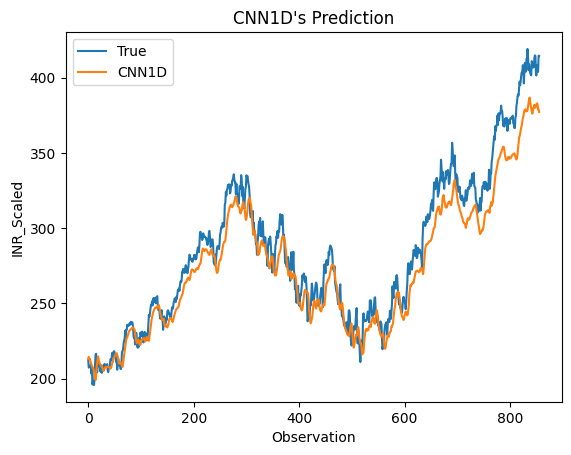

In [154]:
plt.plot(y_test_cnn, label='True')
plt.plot(y_pred_test_cnn, label='CNN1D')
plt.title("CNN1D's Prediction")
plt.xlabel('Observation')
plt.ylabel('INR_Scaled')
plt.legend()
plt.show()

# Calculating All Models R2 Score ,RMSE and MASE

In [155]:
models = ['LSTM', 'GRU', 'SimpleRNN', 'CNN1D']
r2_scores = [
    r2_score(y_test, y_pred_test_lstm),
    r2_score(y_test, y_pred_test_gru),
    r2_score(y_test, y_pred_test_simplernn),
    r2_score(y_test_cnn, y_pred_test_cnn)
]

rmse_scores = [
    np.sqrt(mean_squared_error(y_test, y_pred_test_lstm)),
    np.sqrt(mean_squared_error(y_test, y_pred_test_gru)),
    np.sqrt(mean_squared_error(y_test, y_pred_test_simplernn)),
    np.sqrt(mean_squared_error(y_test_cnn, y_pred_test_cnn))
]
def mase(y_true, y_pred):
    n = y_true.shape[0]
    d = np.abs(np.diff(y_true, axis=0)).sum() / (n-1)
    errors = np.abs(y_true - y_pred)
    return errors.mean() / d

mase_scores = [
    mase(y_test, y_pred_test_lstm),
    mase(y_test, y_pred_test_gru),
    mase(y_test, y_pred_test_simplernn),
    mase(y_test_cnn, y_pred_test_cnn)
]

comparison_df = pd.DataFrame({
    'Model': models,
    'R2 Score': r2_scores,
    'RMSE': rmse_scores,
    'MASE': mase_scores
})

# Plotting Models R2 score Comparison

In [156]:
import matplotlib.pyplot as plt

# Define bar width and positions
bar_width = 0.25
index = np.arange(len(models))



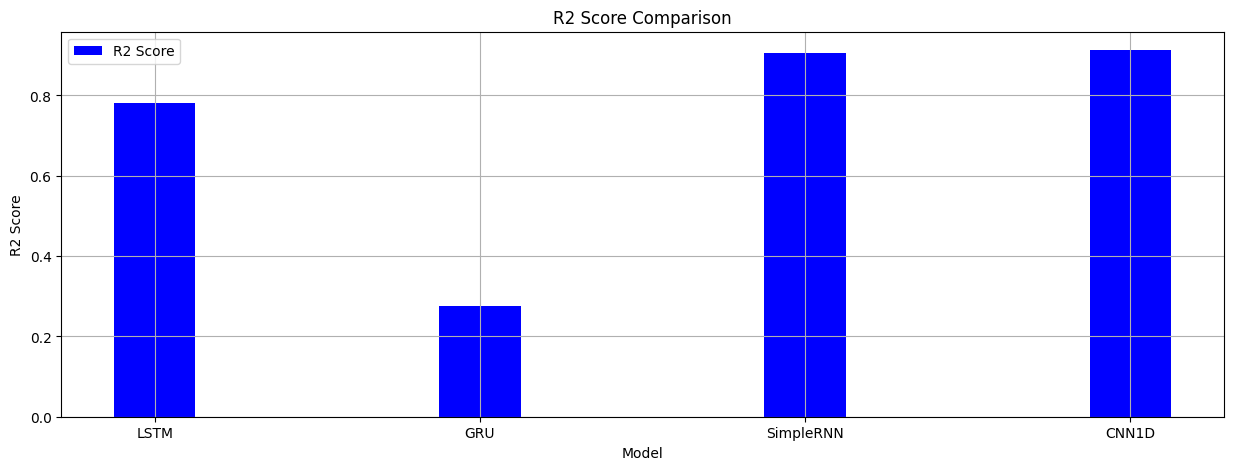

In [157]:
plt.figure(figsize=(15, 5))
plt.bar(index, r2_scores, bar_width, color='b', label='R2 Score')
plt.xlabel('Model')
plt.ylabel('R2 Score')
plt.title('R2 Score Comparison')
plt.xticks(index, models)
plt.legend()
plt.grid(True)
plt.show()


# Plotting Models RMSE Comparison

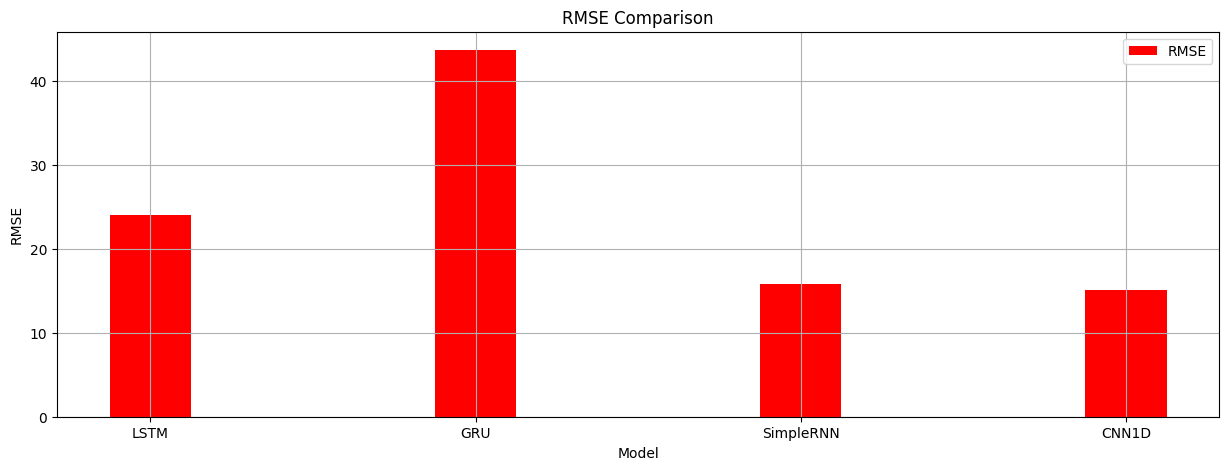

In [158]:
plt.figure(figsize=(15, 5))
plt.bar(index, rmse_scores, bar_width, color='r', label='RMSE')
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.title('RMSE Comparison')
plt.xticks(index, models)
plt.legend()
plt.grid(True)
plt.show()

# Plotting MASE Comparison

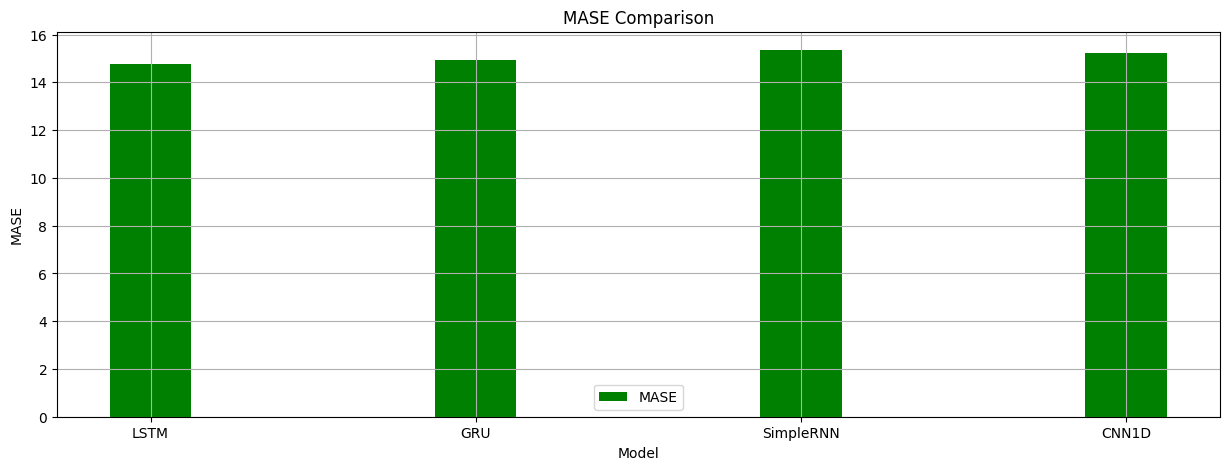

In [159]:
plt.figure(figsize=(15, 5))
plt.bar(index, mase_scores, bar_width, color='g', label='MASE')
plt.xlabel('Model')
plt.ylabel('MASE')
plt.title('MASE Comparison')
plt.xticks(index, models)
plt.legend()
plt.grid(True)
plt.show()

# Comparison Table


In [160]:
comparison_df

,Model,R2 Score,RMSE,MASE
0,LSTM,0.780445,24.047710,14.786399
1,GRU,0.275612,43.680562,14.929584
2,SimpleRNN,0.904520,15.858386,15.353540
3,CNN1D,0.912968,15.100681,15.249923


**Saving R2 score,RMSE and MASE of all Model in excel**

In [161]:
comparison_df.to_excel('ModelComparisonResults.xlsx', index=False)

# Plotting All Models Predictions

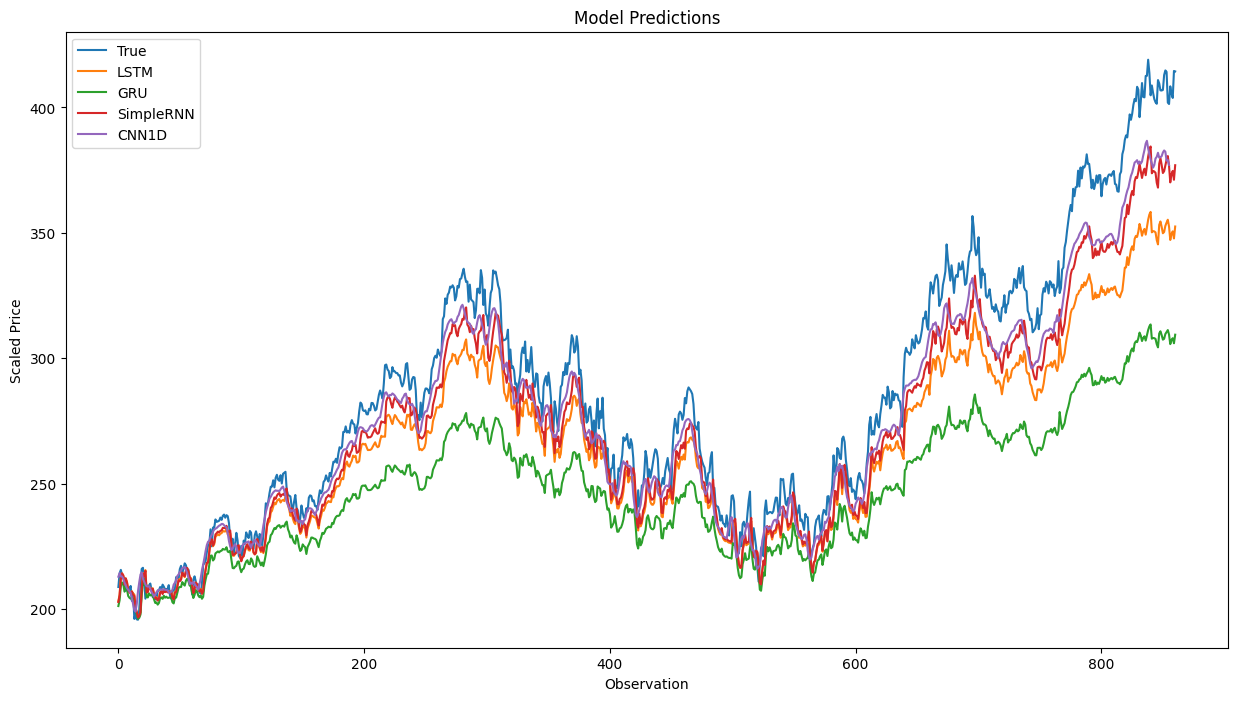

In [162]:
plt.figure(figsize=(15, 8))
plt.plot(y_test, label='True')
plt.plot(y_pred_test_lstm, label='LSTM')
plt.plot(y_pred_test_gru, label='GRU')
plt.plot(y_pred_test_simplernn, label='SimpleRNN')
plt.plot(y_pred_test_cnn, label='CNN1D')
plt.title("Model Predictions")
plt.xlabel('Observation')
plt.ylabel('Scaled Price')
plt.legend()
plt.show()

# Conclusion

It is impossible to  get a model that can 99% predict the price without any error, there are too many factors can affect the
stock prices. So, we cannot hope there is a perfect model, but the general trend of predicted price is in line with the actual data, so the trader could have an indicator to reference, and makes trading decision by himself.


Further, we can improve the model's accuracy by increasing the epochs, trying out different activation functions or even change the model's structure. As exact